In [1]:
import sys  
sys.path.append('../scripts/')
from mcl import *
from kf import * 

In [2]:
class EstimatedLandmark(Landmark): ###fastslam4estimatedlm
    def __init__(self):
        super().__init__(0,0)                      #姿勢を元のクラスのposeに設定
        self.cov = np.array([[1,0], [0,2]]) #描画のテスト用の値。後でNoneに
        
    def draw(self, ax, elems): 
        if self.cov is None:  #共分散が設定されていないときは描画しない
            return
        
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        e = sigma_ellipse(self.pos, self.cov, 3)
        elems.append(ax.add_patch(e))

In [3]:
class MapParticle(Particle): ###fastslam4mapparticle
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map()
        
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())

In [4]:
class FastSlam(Mcl):  ###fastslam4fastslam
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)] #追加
        self.ml = self.particles[0] #最尤のパーティクルを新しく作ったパーティクルのリストの先頭にしておく
        
    def draw(self, ax, elems): #追加
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)

In [5]:
class FastSlamAgent(MclAgent): 
    def __init__(self, time_interval, nu, omega, particle_pose, landmark_num, particle_num=100, \
                 motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        super().__init__(time_interval, nu, omega, particle_pose, None, particle_num, motion_noise_stds)
    
        self.pf = FastSlam(particle_num, particle_pose, landmark_num, motion_noise_stds) 

    def decision(self, observation):
        return super().decision([])

<IPython.core.display.Javascript object>


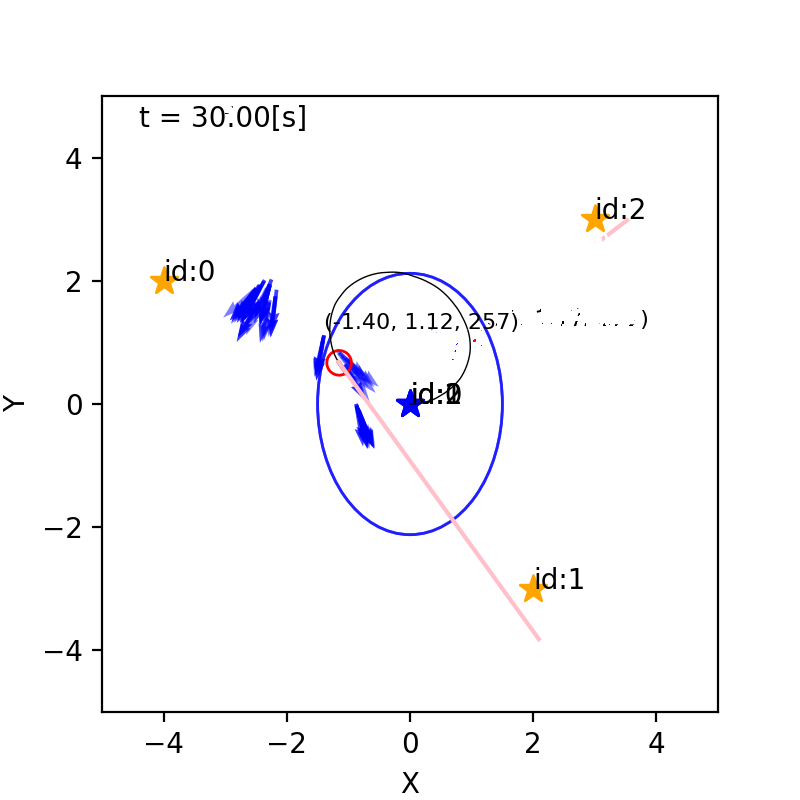

In [6]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    a = FastSlamAgent(time_interval, 0.2, 10.0/180*math.pi, init_pose, len(m.landmarks))
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()